In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import nltk
from tethne.readers import zotero
import matplotlib.pyplot as plt
from helpers import normalize_token, filter_token
import numpy as np
import pandas as pd

# 1.2.2. A Bayesian approach: the linear model

In the last few notebooks, we used a corpus that was generated from a Zotero collection. We read in our metadata from a Zotero RDF/XML document. Sometimes we either don't have access to additional metadata, or simply don't need it for our analysis. A very simple way to encode metadata is to include it in the file name. This isn't a very robust strategy, but for certain use-cases it does the job.

In [4]:
text_root = '../../data/SystemsBiology'
documents = nltk.corpus.PlaintextCorpusReader(text_root, '.+.txt')

In this corpus, the publication year is encoded as the first four characters of the filename. For examples:

In [5]:
documents.fileids()[0]

'2003_1.txt'

So when we generate our conditional distributions, we can simply convert those first four characters to an integer.

In [6]:
int(documents.fileids()[0][:4])

2003

## Review: OLS regression + permutation test

In the code-cells below, we repeat the procedure from the previous notebook to fit a linear regression model, and then perform a permutation test to assess significance.

In [7]:
word_counts_over_time = nltk.ConditionalFreqDist([
        (int(fileid[:4]), normalize_token(token))
         for fileid in documents.fileids()
         for token in documents.words(fileids=[fileid])
         if filter_token(token)
    ])

In [8]:
word_probs_over_time = nltk.ConditionalProbDist(word_counts_over_time, nltk.MLEProbDist)

In [9]:
organism_data = pd.DataFrame(columns=['Year', 'Probability'])
for i, (year, counts) in enumerate(word_probs_over_time.items()):
    organism_data.loc[i] = [year, counts.prob('organism')]

In [10]:
organism_data

,Year,Probability
0,2003,0.002268
1,2004,0.003743
2,2005,0.002191
3,2006,0.001522
4,2007,0.000906
5,2008,0.001088
6,2009,0.000944
7,2010,0.001748
8,2011,0.002160
9,2012,0.000882


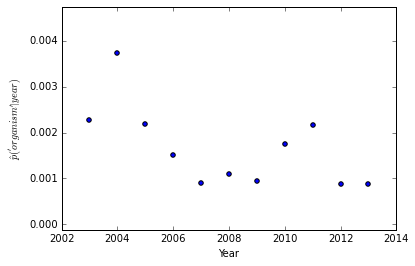

In [11]:
plt.scatter(organism_data.Year, organism_data.Probability)
plt.ylim(organism_data.Probability.min() - 0.001, 
         organism_data.Probability.max() + 0.001)
plt.ylabel('$\\hat{p}(\'organism\'|year)$')
plt.xlabel('Year')
plt.show()

^Beta: -0.000163374366375
^Beta_0: 0.329722373929
r-squared: 0.37234130934
p: 0.0461889764899


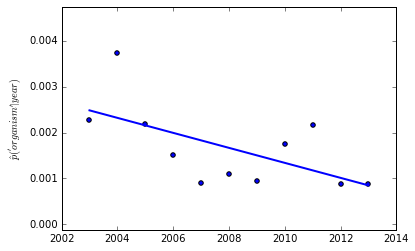

In [12]:
from scipy.stats import linregress
Beta, Beta0, r, p, stde = linregress(organism_data.Year, organism_data.Probability)

print '^Beta:', Beta
print '^Beta_0:', Beta0
print 'r-squared:', r*r
print 'p:', p

plt.scatter(organism_data.Year, organism_data.Probability)
plt.plot(organism_data.Year, Beta0 + Beta*organism_data.Year, lw=2)
plt.ylim(organism_data.Probability.min() - 0.001, 
         organism_data.Probability.max() + 0.001)
plt.ylabel('$\\hat{p}(\'organism\'|year)$')
plt.show()

In [13]:
samples = pd.DataFrame(columns=['Beta_pi', 'Beta0_pi'])
for i in xrange(1000):
    shuffled_probability = np.random.permutation(organism_data.Probability)
    Beta_pi, Beta0_pi, _, _, _ = linregress(organism_data.Year, shuffled_probability)
    samples.loc[i] = [Beta_pi, Beta0_pi]

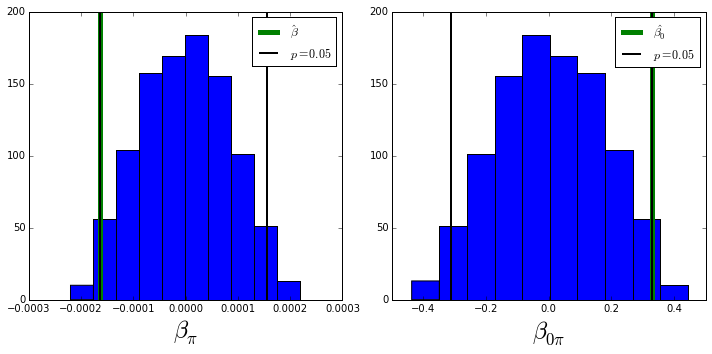

In [14]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.hist(samples.Beta_pi)    # Histogram of Beta values from permutations.
plt.plot([Beta, Beta], [0, 200],     # Beta from the observed data.
         lw=5, label='$\\hat{\\beta}$')

# Plot the upper and lower bounds of the inner 95% probability.
Beta_upper = np.percentile(samples.Beta_pi, 97.5)
Beta_lower = np.percentile(samples.Beta_pi, 2.5)
plt.plot([Beta_upper, Beta_upper], [0, 200], color='k', lw=2, label='$p = 0.05$')
plt.plot([Beta_lower, Beta_lower], [0, 200], color='k', lw=2)

plt.legend()
plt.xlabel('$\\beta_{\\pi}$', fontsize=24)

# Same procedure for Beta0.
plt.subplot(122)
plt.hist(samples.Beta0_pi)
plt.plot([Beta0, Beta0], [0, 200], lw=5, label='$\\hat{\\beta_0}$')

Beta0_upper = np.percentile(samples.Beta0_pi, 97.5)
Beta0_lower = np.percentile(samples.Beta0_pi, 2.5)
plt.plot([Beta0_upper, Beta0_upper], [0, 200], color='k', lw=2, label='$p = 0.05$')
plt.plot([Beta0_lower, Beta0_lower], [0, 200], color='k', lw=2)

plt.legend()
plt.xlabel('$\\beta_{0\\pi}$', fontsize=24)
plt.tight_layout()
plt.show()

^Beta: -0.000163374366375
^Beta_0: 0.329722373929
r-squared: 0.37234130934
p: 0.0461889764899


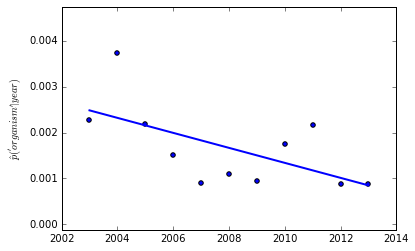

In [15]:
from scipy.stats import linregress
Beta, Beta0, r, p, stde = linregress(organism_data.Year, organism_data.Probability)

print '^Beta:', Beta
print '^Beta_0:', Beta0
print 'r-squared:', r*r
print 'p:', p

plt.scatter(organism_data.Year, organism_data.Probability)
plt.plot(organism_data.Year, Beta0 + Beta*organism_data.Year, lw=2)
plt.ylim(organism_data.Probability.min() - 0.001, 
         organism_data.Probability.max() + 0.001)
plt.ylabel('$\\hat{p}(\'organism\'|year)$')

# plt.fill_between()

plt.show()

## A Bayesian approach

Now we'll try to fit a similar linear model, this time in a Bayesian framework. One notable difference is that we will use raw word counts (not frequencies) modeled using a Poisson distribution (rather than a normal distribution). But we'll still fit a simple linear model.

In [16]:
import pymc

In [17]:
document_index = pd.DataFrame(columns=['Year', 'File'])
for i, fileid in enumerate(documents.fileids()):
    year = int(fileid[:4]) 
    document_index.loc[i] = [year, fileid]

Instead of raw frequencies, we'll use token counts. The Poisson assumes that we are counting events (tokens) within periods/areas of equal size. So we'll ignore document boundaries, and obtain counts over equally-sized chunks of each annual subcorpus.

In [18]:
organism_data = pd.DataFrame(columns=['Year', 'Count'])
i = 0
for year, indices in document_index.groupby('Year').groups.items():
    fileids = document_index.ix[indices].File
    tokens = [normalize_token(token)    # The tokens in this year.
              for token in documents.words(fileids=fileids)
              if filter_token(token)]    
            
    N = len(tokens)    # Number of tokens in this year.
    chunk_size = 200    # This shouldn't be too large.
    for x in xrange(0, N, chunk_size):
        current_chunk = tokens[x:x+chunk_size]    
        count = nltk.FreqDist(current_chunk)['organism']

        # Store the counts for this chunk as an observation.
        organism_data.loc[i] = [year, count]
        i += 1    # Increment the index variable.

The histograms below summarize the observed count data for each year.

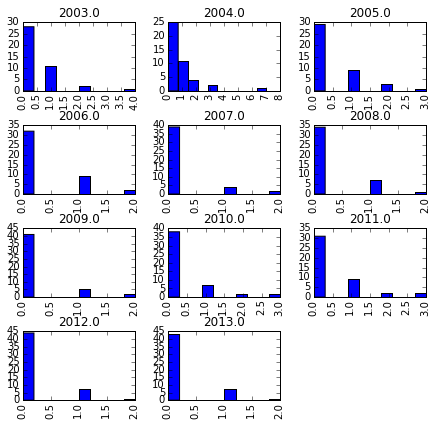

In [19]:
organism_data.hist(column='Count', by='Year', figsize=(7, 7))
plt.show()

It's helpful to view the data as a single scatterplot. I've tuned down the opacity on points, so that it's easier to see relative density. The orange dots show the mean count for each year.

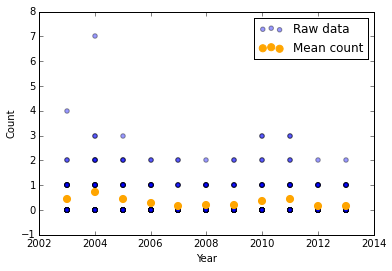

In [20]:
organism_data.plot(kind='scatter', x='Year', y='Count', 
                   alpha=0.4, label='Raw data')
means = organism_data.groupby('Year').mean()
plt.scatter(means.index, means.Count, 
            color='orange', s=50, label='Mean count')
plt.legend(loc='best')
plt.show()

Our linear model here is pretty similar to the original linear model, in that it takes the form $Y = \beta_0 + \beta X$. In this case, our response variable is the rate parameter $\lambda$ for the count data, which we model as Poisson. Instead of using raw years (2003, 2004, etc.), we'll use year-offsets (0, 1, 2, etc).

In [21]:
# Instead of using values in the 2000s, we'll use the
#  offset from the start. So 2003 is year 0, 2004 is
#  year 1, etc.
X = organism_data.Year - organism_data.Year.min()

# Intercept.
Beta0 = pymc.Normal('Beta0', 0., 20, value=1.)

# "Slope" / coefficient.
Beta = pymc.Normal('Beta', 0., 20, value=1.)

word_count = pymc.Poisson('word_count', 
                          mu=Beta0 + Beta*X,    # Here's the line.
                          value=organism_data.Count, 
                          observed=True)
model = pymc.Model({
    'Beta0': Beta0,
    'Beta': Beta,
    'word_count': word_count
})

``M`` (below) is our MCMC simulation.

In [22]:
M = pymc.MCMC(model)

In [23]:
M.sample(iter=100000, burn=10000, thin=50)

 [-----------------100%-----------------] 100000 of 100000 complete in 33.6 sec

Plotting Beta
Plotting Beta0


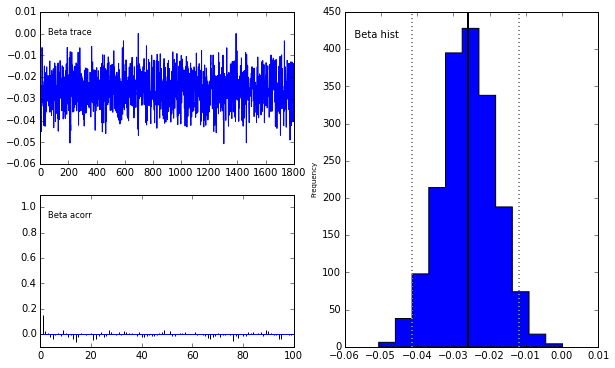

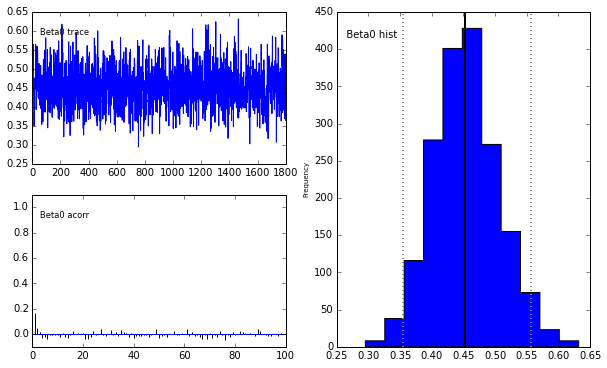

In [24]:
pymc.Matplot.plot(M)

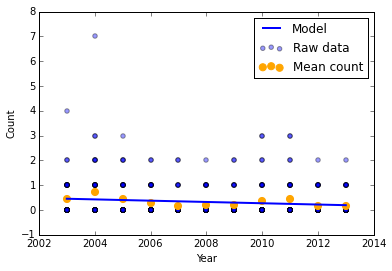

In [25]:
organism_data.plot(kind='scatter', x='Year', y='Count', alpha=0.4, label='Raw data')
means = organism_data.groupby('Year').mean()
plt.scatter(means.index, means.Count, color='orange', s=50, label='Mean count')

years = organism_data.Year.unique()
years_offset = years - years.min()
Beta0_mean = M.Beta0.trace()[:].mean()
Beta_mean = M.Beta.trace()[:].mean()
predicted_counts = Beta0_mean + Beta_mean*years_offset
plt.plot(years, predicted_counts, lw=2, label='Model')

plt.legend(loc='best')
plt.show()